In [ ]:
# Init global infos

import numpy as np
from tensorflow import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import tensorflow as tf
from google.colab import files
import io



inputs = (
    ("age", ("continuous",)), 
    ("workclass", ("Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked")), 
    ("fnlwgt", ("continuous",)), 
    ("education", ("Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool")), 
    ("education-num", ("continuous",)), 
    ("marital-status", ("Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse")), 
    ("occupation", ("Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces")), 
    ("relationship", ("Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried")), 
    ("race", ("White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black")), 
    ("sex", ("Female", "Male")),
    ("capital-gain", ("continuous",)), 
    ("capital-loss", ("continuous",)), 
    ("hours-per-week", ("continuous",)), 
    ("native-country", ("United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"))
)

input_shape = []
for i in inputs:
    count = len(i[1 ])
    input_shape.append(count)
input_dim = sum(input_shape)
print("input_shape:", input_shape)
print("input_dim:", input_dim)
print()


outputs = (0, 1)  # (">50K", "<=50K")
output_dim = 2  # len(outputs)
print("output_dim:", output_dim)
print()


input_shape: [1, 8, 1, 16, 1, 7, 14, 6, 5, 2, 1, 1, 1, 41]
input_dim: 105

output_dim: 2



In [ ]:
# Functions to load and prepare data

def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def find_means_for_continuous_types(X):
    means = []
    for col in range(len(X[0])):
        summ = 0
        count = 0.000000000000000000001
        for value in X[:, col]:
            if isFloat(value): 
                summ += float(value)
                count +=1
        means.append(summ/count)
    return means

def prepare_data(raw_data, means):
    
    X = raw_data[:, :-1]
    y = raw_data[:, -1:]
    
    # X:
    def flatten_persons_inputs_for_model(person_inputs):
        global inputs
        global input_shape
        global means
        float_inputs = []

        for i in range(len(input_shape)):
            features_of_this_type = input_shape[i]
            is_feature_continuous = features_of_this_type == 1

            if is_feature_continuous:
                mean = means[i]
                if isFloat(person_inputs[i]):
                    if mean != 0:
                        scale_factor = 1/(2*mean)  # we prefer inputs mainly scaled from -1 to 1.
                    else:
                        scale_factor = 1
                    float_inputs.append(float(person_inputs[i])*scale_factor)
                else:
                    float_inputs.append(mean)
            else:
                for j in range(features_of_this_type):
                    feature_name = inputs[i][1][j]
                    
                    if feature_name == person_inputs[i]:
                        float_inputs.append(1.)
                    else:
                        float_inputs.append(0)
        return float_inputs
    
    new_X = []
    for person in range(len(X)):
        formatted_X = flatten_persons_inputs_for_model(X[person])
        new_X.append(formatted_X)
    new_X = np.array(new_X)
    
    # y:
    new_y = []
    for i in range(len(y)):
        if y[i] == ">50k":
            new_y.append((1, 0))
        else:  # y[i] == "<=50k":
            new_y.append((0, 1))
    new_y = np.array(new_y)
    
    return (new_X, new_y)

In [ ]:
# Building training and test data
uploaded = files.upload()

Saving adult.data.txt to adult.data.txt


In [ ]:
uploaded = files.upload()
##test_data = np.genfromtxt(io.BytesIO(uploaded['adult.test.txt']), delimiter=', ', dtype=str, autostrip=True)
training_data = np.genfromtxt('adult.data.txt', delimiter=', ', dtype=str, autostrip=True)
print("Training data count:", len(training_data))
test_data = np.genfromtxt('adult.test.txt', delimiter=', ', dtype=str, autostrip=True)
print("Test data count:", len(test_data))

Saving adult.test.txt to adult.test.txt
Training data count: 32561
Test data count: 16281


In [ ]:
#prepare dataset for training
means = find_means_for_continuous_types(np.concatenate((training_data, test_data), 0))
print("Mean values for data types (if continuous):", means)
X_train_general, y_train_general = prepare_data(training_data, means)
X_test_general, y_test_general = prepare_data(test_data, means)

df_data_train = pd.DataFrame(X_train_general).copy()
X_train_male = df_data_train[df_data_train[59] == 0].to_numpy()
X_train_female = df_data_train[df_data_train[59] == 1].to_numpy()

df_data_test = pd.DataFrame(X_test_general).copy()
X_test_male = df_data_test[df_data_test[59] == 0].to_numpy()
X_test_female = df_data_test[df_data_test[59] == 1].to_numpy()

y_train_df = pd.DataFrame(y_train_general).copy()
y_train_male = y_train_df[df_data_train[59] == 0].to_numpy()
y_train_female = y_train_df[df_data_train[59] == 1].to_numpy()

y_test_df = pd.DataFrame(y_test_general).copy()
y_test_male = y_test_df[df_data_test[59] == 0].to_numpy()
y_test_female = y_test_df[df_data_test[59] == 1].to_numpy()

Mean values for data types (if continuous): [38.64358543876172, 0.0, 189664.13459727284, 0.0, 10.078088530363212, 0.0, 0.0, 0.0, 0.0, 0.0, 1079.0676262233324, 87.50231358257237, 40.422382375824085, 0.0, 0.0]


In [ ]:
input1 = keras.layers.Input(shape=105)
dense1 = keras.layers.Dense(128, activation='sigmoid')(input1)
dense3 = keras.layers.Dense(20, activation='sigmoid')(dense1)
output = keras.layers.Dense(2, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history2 = model.fit(X_train_general, y_train_general, epochs=20, batch_size=512, validation_split=0.1, verbose=1)

# Evaluate training
score = model.evaluate(X_test_general, y_test_general, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 105)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               13568     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 16,190
Trainable params: 16,190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
58/58 [==============================] - 1s 9ms/step - loss: 0.5322 - accuracy: 0.7471 - val_loss: 0.4854 - val_accuracy: 0.7587
Epoch 2/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4342 - accuracy: 0.7960 - val_loss: 0.389

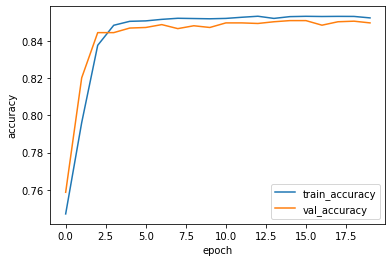

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
plt.show()

In [ ]:
# calculate confusion matrix and fairness measures for baseline model
y_pred_female = model.predict(X_test_female)
y_pred_female = np.argmax(y_pred_female, axis=1)

y_pred_male = model.predict(X_test_male)
y_pred_male = np.argmax(y_pred_male, axis=1)

y_test_female_binary = np.argmax(y_test_female, axis=1)
y_test_male_binary = np.argmax(y_test_male, axis=1)

from sklearn.metrics import confusion_matrix
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female_binary, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male_binary, y_pred_male).ravel()

prob_true_beutel_female = (tp_female + fp_female)/y_test_female.shape[0]
print("prob_1 female (beutel):", prob_true_beutel_female)
acc_female = (tp_female + tn_female)/y_test_female.shape[0]
print("acc female:", acc_female)
tpr_female = tp_female/(tp_female + fn_female)
print("tpr female:",tpr_female)
ppv_female = tp_female/(tp_female + fp_female)
print("ppv female:",ppv_female)
tnr_female = tn_female/(tn_female + fp_female)
print("tnr female:",tnr_female)

print("---------------------------------------------------")
## male
prob_true_beutel_male = (tp_male + fp_male)/y_test_male.shape[0]
print("prob_1 male (beutel):", prob_true_beutel_male)
acc_male = (tp_male + tn_male)/y_test_male.shape[0]
print("acc male:", acc_male)
tpr_male = tp_male/(tp_male + fn_male)
print("tpr male:", tpr_male)
ppv_male = tp_male/(tp_male + fp_male)
print("ppv male:",ppv_male)
tnr_male = tn_male/(tn_male + fp_male)
print("tnr male:",tnr_male)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel_female - prob_true_beutel_male)
pred_parity = abs(ppv_female - ppv_male)
equal_opportunity = abs(tpr_female - tpr_male) ## = equality_gap_1
equality_gap_0_beutel = abs(tnr_female - tnr_male)
accuracy_gap = abs(acc_female - acc_male)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)

prob_1 female (beutel): 0.9219701162147206
acc female: 0.92897989300867
tpr female: 0.9774373835644794
ppv female: 0.9447779111644657
tnr female: 0.5322033898305085
---------------------------------------------------
prob_1 male (beutel): 0.7600368324125231
acc male: 0.8128913443830571
tpr male: 0.9091267753813782
ppv male: 0.8375333171795493
tnr male: 0.5881449631449631
---------------------------------------------------
parity gap (beutel): 0.16193328380219751
predictive parity: 0.10724459398491648
equal opportunity (equality gap 1 (beutel)): 0.0683106081831012
equality gap 0 (beutel): 0.055941573314454596
accuracy gap: 0.11608854862561291


In [ ]:
# Retrain last layer to predict sensitive attribute (gender)
y_test_woman_zeros = tf.keras.utils.to_categorical(np.zeros((y_test_female.shape[0],1)), num_classes = 2)
y_test_man_ones = tf.keras.utils.to_categorical(np.ones((y_test_male.shape[0],1)), num_classes = 2)

y_train_woman_zeros = tf.keras.utils.to_categorical(np.zeros((y_train_female.shape[0],1)), num_classes = 2)
y_train_man_ones = tf.keras.utils.to_categorical(np.ones((y_train_male.shape[0],1)), num_classes = 2)

model_1 = keras.models.clone_model(model)
model_1.set_weights(model.get_weights()) 

model_1._layers.pop()
for layer in model_1.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_1.layers[-1].output
output = keras.layers.Dense(2, activation="softmax", name="output")(last)
model_1 = keras.models.Model(model_1.input, output)

for layer in model_1.layers:
    print(layer, layer.trainable)
    
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_1.summary()

history = model_1.fit(np.concatenate((X_train_male,X_train_female)), np.concatenate((y_train_man_ones, y_train_woman_zeros)),epochs=5,
    shuffle=True,
    verbose=1)
score = model_1.evaluate(X_test_male, y_test_man_ones, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x64945b150> False
<tensorflow.python.keras.layers.core.Dense object at 0x648925b10> False
<tensorflow.python.keras.layers.core.Dense object at 0x64945bc90> False
<tensorflow.python.keras.layers.core.Dense object at 0x6494580d0> True
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 105)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               13568     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2580      
_________________________________________________________________
output (Dense)               (None, 2)                 42        
Total params: 16,190
Trainable params: 42
Non-trainable params: 16,148
___________________

In [ ]:
# retrain last layer of baseline model to predict gender and income
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 
model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
outputSet = keras.layers.Dense(2, activation="softmax", name="outputSet")(last)
outputIncome = keras.layers.Dense(2, activation="softmax", name="outputIncome")(last)
model_new = keras.models.Model(model_new.input, [outputIncome, outputSet])

for layer in model_new.layers:
    print(layer, layer.trainable)
    
model_new.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"outputSet":'accuracy', "outputIncome":'accuracy'})

model_new.summary()

y_train_male_ = np.ones(21790)
y_train_female_ = np.zeros(10771)

y_test_male_ = np.ones(10860)
y_test_female_ = np.zeros(5421)

y_train_set = keras.utils.to_categorical(np.concatenate((y_train_male_,y_train_female_)), 2)
y_test_set = keras.utils.to_categorical(np.concatenate((y_test_male_,y_test_female_)), 2)

X_train_male_general = df_data_train[df_data_train[59] == 0].to_numpy()
X_train_female_general = df_data_train[df_data_train[59] == 1].to_numpy()

indices = tf.range(start=0, limit=tf.shape(np.concatenate((X_train_male_general, X_train_female_general)))[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

X_train_ = tf.gather(np.concatenate((X_train_male_general, X_train_female_general)), shuffled_indices)
y_train_ = tf.gather(np.concatenate((y_train_male, y_train_female)), shuffled_indices)
y_train_set = tf.gather(y_train_set, shuffled_indices)

history = model_new.fit(X_train_, [y_train_,y_train_set],
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    shuffle = 'TRUE')
score = model_new.evaluate(np.concatenate((X_test_male_general, X_test_female_general)), [np.concatenate((y_test_male, y_test_female)),y_test_set], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8d72804c50> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f8d72804710> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f8d727d2a90> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f8d72826400> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f8d72746cc0> True
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          13568       input_1[0][0]                    
__________________________________________________________________________________________________
dens

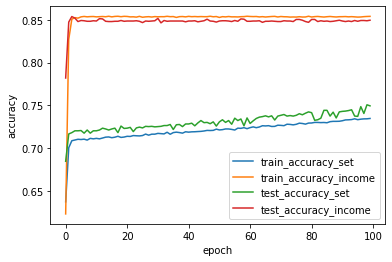

In [ ]:
plt.plot(history.history['outputSet_accuracy'])
plt.plot(history.history['outputIncome_accuracy'])
plt.plot(history.history['val_outputSet_accuracy'])
plt.plot(history.history['val_outputIncome_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy_set', 'train_accuracy_income','test_accuracy_set','test_accuracy_income'], loc='best')
plt.show()

In [ ]:
# preparation to get histogram of distribution of baseline model
intermediate_layer_model = keras.models.Model(inputs = model.input, outputs = model.get_layer("dense_1").output)
intermediate_output_male = intermediate_layer_model.predict(X_train_male)
intermediate_output_female = intermediate_layer_model.predict(X_train_female)

In [ ]:
input2 = keras.layers.Input(shape=20)
dense2_1 = keras.layers.Dense(1)(input2)
output2 = keras.layers.Dense(2, activation='softmax')(dense2_1)

model2 = keras.Model(inputs=[input2], outputs=[output2])

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

rep_train_x = np.concatenate((intermediate_output_male, intermediate_output_female))
train_y = np.concatenate((y_train_male, y_train_female))

history = model2.fit([rep_train_x], train_y,
                     batch_size=128,
                     epochs=20,
                     verbose=1,
                     shuffle = True)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 4         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
255/255 [==============================] - 1s 4ms/step - loss: 0.5039 - accuracy: 0.7810
Epoch 2/20
255/255 [==============================] - 1s 4ms/step - loss: 0.3567 - accuracy: 0.8408
Epoch 3/20
255/255 [==============================] - 1s 4ms/step - loss: 0.3219 - accuracy: 0.8527
Epoch 4/20
255/255 [==============================] - 1s 4ms/step - loss: 0.3174 - accuracy: 

In [ ]:
intermediate_layer_model = keras.models.Model(inputs = model2.input, outputs = model2.get_layer("dense_9").output)
intermediate_output_male2 = intermediate_layer_model.predict(intermediate_output_male)
intermediate_output_female2 = intermediate_layer_model.predict(intermediate_output_female)

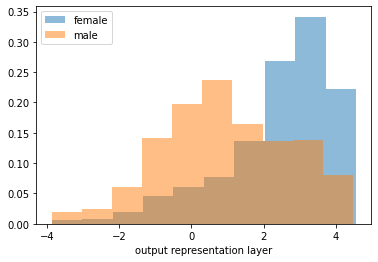

In [ ]:
plt.hist(intermediate_output_female2, density = True, alpha=0.5, label='female')
plt.hist(intermediate_output_male2, density = True, alpha=0.5, label='male')
plt.xlabel("output representation layer")
plt.legend(loc='best')
plt.savefig("hist_rep1.png")